# Objectron 3D Projection Tutorial

This notebook shows how to project 3D annotated points to images from intrinsic matrix or camera projection matrix.

The data is retrieved from [hub](https://app.activeloop.ai/organizations/google/datasets). 

In [1]:
import cv2
import hub
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def project_by_intrinsics(element):
    """
    Project using camera intrinsics.

    Objectron frame (x down, y right, z in); 
    H-Z frame (x right, y down, z out); 
    Objectron intrinsics has px and py swapped;
    px and py are from original image size (1440, 1920);

    Approach 1:
    To transform Objectron frame to H-Z frame,
    we need to negate z and swap x and y;
    To modify intrinsics, we need to swap px, py.

    Or alternatively, approach 2:
    we change the sign for z and swap x and y after projection.
    
    Reference
    https://github.com/google-research-datasets/Objectron/issues/39#issuecomment-835509430
    https://amytabb.com/ts/2019_06_28/
    """
    vertices_3d = element['point_3d'].reshape(9, 3)
    # Objectron to H-Z frame
    vertices_3d[:, 2] = - vertices_3d[:, 2]    
    intr = element['camera_intrinsics'].reshape(3, 3)
    # scale intrinsics from (1920, 1440) to (640, 480)
    intr[:2, :] = intr[:2, :] / np.array([[1920],[1440]]) * np.array([[640],[480]])
    point_2d = intr @ vertices_3d.T 
    point_2d[:2, :] = point_2d[:2, :] / point_2d[2, :]
    # landscape to portrait swap x and y.
    point_2d[[0, 1], :] = point_2d[[1, 0], :]
    arranged_points = point_2d.T[:, :2]
    return arranged_points


def project_by_camera_projection(element):
    """
    Projection using camera projection matrix.
    
    Reference: 
    function project_points in https://github.com/google-research-datasets/Objectron/blob/master/notebooks/objectron-geometry-tutorial.ipynb
    http://www.songho.ca/opengl/gl_projectionmatrix.html    
    """
    vertices_3d = element['point_3d'].reshape(9, 3)
    vertices_3d_homg = np.concatenate((vertices_3d, np.ones_like(vertices_3d[:, :1])), axis = -1).T
    vertices_2d_proj = np.matmul(element['camera_projection'].reshape(4, 4), vertices_3d_homg)
    # Project the points
    points2d_ndc = vertices_2d_proj[:-1, :] / vertices_2d_proj[-1, :]
    points2d_ndc = points2d_ndc.T
    # Convert the 2D Projected points from the normalized device coordinates to pixel values
    x = points2d_ndc[:, 1]
    y = points2d_ndc[:, 0]
    pt2d = np.copy(points2d_ndc)
    pt2d[:, 0] = (1 + x) / 2 * element['image_width']
    pt2d[:, 1] = (1 + y) / 2 * element['image_height']
    arranged_points = pt2d[:, :2]
    return arranged_points


def project_by_point2d(element):
    """
    Directly using 2D projected points from the annotation file. 
    The projections are normalized, so we scale them with the 
    image's height and width to get the pixel value.
    """
    arranged_points = element['point_2d'].reshape(9, 3)
    arranged_points[:, 0] = arranged_points[:, 0] * element['image_width']
    arranged_points[:, 1] = arranged_points[:, 1] * element['image_height']
    return arranged_points[:, :2]


def draw_box(img, arranged_points):
    """
    plot arranged_points on img.
    arranged_points: list of points [[x, y]] in image coordinate. 
    """
    RADIUS = 10
    COLOR = (255, 255, 255)
    EDGES = [
      [1, 5], [2, 6], [3, 7], [4, 8],  # lines along x-axis
      [1, 3], [5, 7], [2, 4], [6, 8],  # lines along y-axis
      [1, 2], [3, 4], [5, 6], [7, 8]   # lines along z-axis
    ] 
    for i in range(arranged_points.shape[0]):
        x, y = arranged_points[i]
        cv2.circle(img, (int(x), int(y)), RADIUS, COLOR, -10)
    for edge in EDGES:
        start_points = arranged_points[edge[0]]
        start_x = int(start_points[0])
        start_y = int(start_points[1])
        end_points = arranged_points[edge[1]]
        end_x = int(end_points[0])
        end_y = int(end_points[1])
        cv2.line(img, (start_x, start_y), (end_x, end_y), COLOR, 2)
    plt.imshow(img)

In [3]:
# Download a sample frame from hub
bikes = hub.Dataset("google/bike")
frame_id = 0
element=bikes[frame_id].compute()

Plot directly from point2d


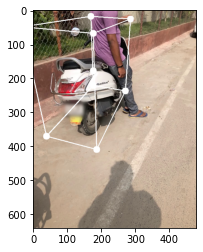

In [4]:
print('Plot directly from point2d')
pt2d_point2d = project_by_point2d(element.copy())
draw_box(element['image'].copy(), pt2d_point2d)

Project using camera_projection


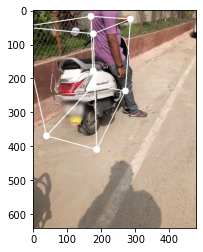

In [5]:
print('Project using camera_projection')
pt2d_cam_proj = project_by_camera_projection(element.copy())
draw_box(element['image'].copy(), pt2d_cam_proj)

Project using camera_intrinsics


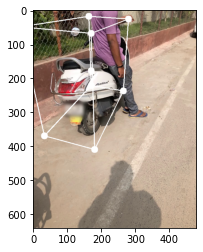

In [6]:
print('Project using camera_intrinsics')
pt2d_intr = project_by_intrinsics(element.copy())
draw_box(element['image'].copy(), pt2d_intr)